In [2]:

import sys
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import csv

import pandas as pd
import itertools

from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset



In [4]:
# Geometry
length = 1e-2                 # Length of the rod

# Material properties
rho = 2760.0                      # Density of AL380 (kg/m^3)
rho_l = rho
rho_s = rho *1.5
rho_m = rho
k = 1090.0 *1.5                         # W/m-K
k_l = k                        # W/m-K
k_s = k                        # W/m-K
k_m = k                        # W/m-K
cp = 963.0                        # Specific heat of aluminum (J/kg-K)
cp_l = cp
cp_s = cp
cp_m = cp
alpha = k / (rho * cp)            # Thermal diffusivity
alpha_l = alpha
alpha_s = alpha
aplha_m = alpha
print('alpha ia',alpha)
#L_fusion = 3.9e3                 # J/kg
L_fusion = 389e3               # J/kg

# Spatial discretization

num_points = 50                  # Number of spatial points
dx = length / (num_points - 1)
print('dx is',dx)
                                   #dt = time_end/num_steps
#num_steps = 200000               # Number of time steps
                                  # num_steps = round(time_end/dt)
                                                              
# Time Discretization  
# 
time_end = 5                 # seconds                         
#num_steps = 10000
# dt = time_end/num_steps
dt = abs(0.5 *(dx**2/alpha))
print('dt is ',dt)
num_steps = round(time_end/dt) +1
print('num_steps is',num_steps)
cfl = 0.5 *(dx**2/alpha)
print('cfl is',cfl)
#dt = time_end / num_steps
time_steps = np.linspace(0, time_end, num_steps + 1)

if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

alpha ia 0.000615151925594835
dx is 0.00020408163265306123
dt is  3.3852867115765984e-05
num_steps is 147699
cfl is 3.3852867115765984e-05
stability criteria satisfied


In [5]:
# Initial Conditions
T_L = 866.0                       #  K -Liquidus Temperature (593 c)
T_S = 811.0                       # K- Solidus Temperature (538 C)


# Initial temperature and phase fields
init_temp = 870.0
temperature = np.full(num_points, init_temp)
phase = np.zeros(num_points)*1.0

# Set boundary conditions
temperature[-1] = 313.0 #(40 C)
phase[-1] = 1.0

temperature[0] = 313.0 #(40 C)
phase[0] = 1.0

# Store initial state in history
temperature_history = [temperature.copy()]
phi_history = [phase.copy()]

#print(temperature_history,phi_history)

In [6]:
# Finite difference method

for m in range(1, num_steps+1):                  # time loop
    for n in range(1,num_points-1):              # space loop, adjusted range
        #print(f"Step {m}, point {n},Temperature: {temperature}, Phase: {phase}")
        if temperature[n] >= T_L:
            temperature[n] = temperature[n] + ((alpha * dt )/ dx**2) * (temperature[n+1] - 2.0 * temperature[n] + temperature[n-1])
            phase[n] = 0
         
            #print(m,n,temperature[n],phase[n])
        elif T_S < temperature[n] < T_L:
            #temperature[n] = temperature[n] - (((k * dt) / (rho*(T_L-T_S)*(cp*(T_L-T_S)-L_fusion)*(dx**2))) * (temperature[n+1] - 2 * temperature[n] + temperature[n-1]))
            temperature[n] = temperature[n] - ((k/(rho*(cp-(L_fusion/(T_L-T_S)))))* (temperature[n+1] - 2 * temperature[n] + temperature[n-1]))
            phase[n] = (T_L - temperature[n]) / (T_L - T_S)
            #print(m,n,temperature[n],phase[n])
         
        elif temperature[n]<T_S:
            temperature[n] = temperature[n] + ((alpha * dt )/ dx**2) * (temperature[n+1] - 2.0 * temperature[n] + temperature[n-1])
            phase[n] = 1
            
        else:
            print("ERROR: should not be here")
         
           # print(m,n,temperature[n],phase[n])
    
    temperature_history.append(temperature.copy())
    phi_history.append(phase.copy())
    #Print for debugging
    #print(f"Step {m}, space{n},Temperature: {temperature}, Phase: {phase}")


#print(temperature_history)
#print(phi_history)




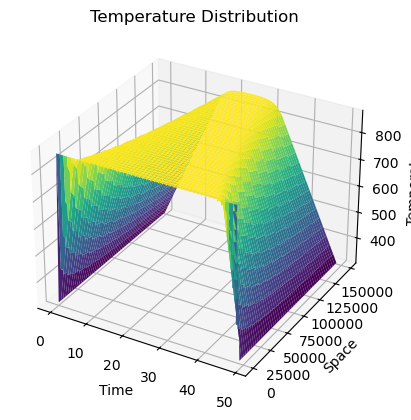

In [8]:
from mpl_toolkits.mplot3d import Axes3D

temperature_history = np.array(temperature_history) 
phi_history = np.array(phi_history)

time_steps = temperature_history.shape[0]
spatial_poitns = temperature_history.shape[1]

time = np.arange(time_steps)
space = np.arange(spatial_poitns)

T,X = np.meshgrid(time,space, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X,T,temperature_history, cmap='viridis')

ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_zlabel('Temperature')
ax.set_title('Temperature Distribution')

plt.show()


c_lamda = 0.1    #material constant

del_Pcr = 25     # difference between P liquidus and P at critical pressure
u_l = 450000         # dynamic viscosity of liquid
beta = (rho_s - rho_l)/ rho_l 
del_Tf = T_L - T_S
   


g = np.array(np.gradient(temperature_history, axis=1))
t_dot = np.array(np.gradient(temperature_history, axis=0))
t_dot = np.where(t_dot <= 0, 1e-10, t_dot)
Main= g /(t_dot**(5/6))
Pcr = (del_Pcr/u_l*beta*del_Tf)**(1/2)
Niyama = c_lamda *(Pcr)
#print(Main)



In [6]:

# Define the neural network architecture
class HeatPINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): # This is the constructor
        super(HeatPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )                                                    

    def forward(self, x, t):                               # This is the forward pass
        input_features = torch.cat([x, t], dim=1)          # Concatenate the input features
        return self.net(input_features)                     # Return the output of the network

# Hyperparameters
hidden_size = 75
learning_rate = 1e-3
epochs = 100
alpha = 0.01  # Adjust this value based on your problem

# Initialize the model
model = HeatPINN(input_size=2, hidden_size=hidden_size, output_size=1)
print(model)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Loss function for data 

def loss_fn_data(u_pred, u_true):
    return nn.MSELoss()(u_pred, u_true)

HeatPINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=75, bias=True)
    (1): ReLU()
    (2): Linear(in_features=75, out_features=75, bias=True)
    (3): ReLU()
    (4): Linear(in_features=75, out_features=1, bias=True)
  )
)


/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Preparing the data for Aye Eye

In [7]:

# Training data preparation
x = torch.linspace(0, 1, num_points).view(-1, 1).requires_grad_(True) # Spatial dimension of length l
t = torch.linspace(0, 5, num_steps+1).view(-1, 1).requires_grad_(True) # Temporal dimension of length T
X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij') # Create a meshgrid of X and T
X = X.reshape(-1, 1)   # Reshape X to a column vector
T = T.reshape(-1, 1)       # Reshape T to a column vector




inputs = torch.cat([X, T], dim=1)

temp_t = torch.tensor(np.array(temperature_history)) # Convert the temperature history to a tensor
phase_t = torch.tensor(np.array(phi_history))          # Convert the phase history to a tensor
temp_inp = temp_t.reshape(-1,1)
phase_inp = phase_t.reshape(-1,1)
print(inputs.shape)
print(T.shape)
print(temp_inp.shape)




torch.Size([7385000, 2])
torch.Size([7385000, 1])
torch.Size([7385000, 1])


Create the custom data set for the training from 

In [8]:


class  SpatiotemporalDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, temp_inp, phase_inp):
        self.inputs = inputs
        self.temp_inp = temp_inp
        self.phase_inp = phase_inp

    def __getitem__(self, index):
        return self.inputs[index], self.temp_inp[index], self.phase_inp[index]

    def __len__(self):
        return len(self.inputs)

# Create the dataset and dataloader   
dataset = SpatiotemporalDataset(inputs, temp_inp, phase_inp)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)



In [9]:

# Record losses for plotting
epoch_losses = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # Predict temperature
    T_pred = model(X, T)   # The model outputs the temperature at each (x, t) coordinate

    # Compute PDE residual

    
    T_pred = T_pred.reshape(X.shape) # Reshape the prediction to match the shape of X
    T_pred_t = torch.autograd.grad(T_pred, T, torch.ones(T.shape, device=T_pred.device), create_graph=True)[0] # Compute the gradient of T_pred w.r.t. t
    T_pred_x = torch.autograd.grad(T_pred, X, torch.ones(X.shape, device=T_pred.device), create_graph=True)[0] # Compute the gradient of T_pred w.r.t. x
    T_pred_xx = torch.autograd.grad(T_pred_x, X, torch.ones(X.shape, device=T_pred.device), create_graph=True)[0] # Compute the second gradient of T_pred w.r.t. x
    
    # PDE Loss
    pde_residual = T_pred_t - alpha * T_pred_xx # Compute the residual of the PDE
    pde_loss = torch.mean(pde_residual ** 2)  # Compute the mean squared error of the PDE residual
    
    # Boundary condition loss
    # Adjust boundary tensors to have the same size in the time dimension as T
    left_boundary = torch.ones(T.shape, device=X.device, requires_grad=True)*500.0
    right_boundary = torch.ones(T.shape, device=X.device, requires_grad=True)*500.0

    bc_loss = torch.mean((model(left_boundary, T) - 500.0) ** 2) \
            + torch.mean((model(right_boundary, T) - 500.0) ** 2)
    
    # Initial condition loss
    ic_loss = torch.mean((model(X, torch.zeros_like(T)) - init_temp) ** 2)
    

    # Data loss

    data_loss = torch.mean((model(X, T) - temp_inp) ** 2)

    # Total loss
    loss = pde_loss + bc_loss + ic_loss + data_loss

    print("pde_loss",pde_loss,"bc_loss",bc_loss,"ic_loss",ic_loss,"data_loss",data_loss)
    epoch_losses.append(loss.item())
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


pde_loss tensor(0.0053, grad_fn=<MeanBackward0>) bc_loss tensor(683324.6250, grad_fn=<AddBackward0>) ic_loss tensor(757120.6250, grad_fn=<MeanBackward0>) data_loss tensor(549101.7881, dtype=torch.float64, grad_fn=<MeanBackward0>)
pde_loss tensor(0.0035, grad_fn=<MeanBackward0>) bc_loss tensor(644616.3750, grad_fn=<AddBackward0>) ic_loss tensor(757057.6875, grad_fn=<MeanBackward0>) data_loss tensor(549020.8965, dtype=torch.float64, grad_fn=<MeanBackward0>)
pde_loss tensor(0.0023, grad_fn=<MeanBackward0>) bc_loss tensor(607247.2500, grad_fn=<AddBackward0>) ic_loss tensor(756997.1250, grad_fn=<MeanBackward0>) data_loss tensor(548945.5079, dtype=torch.float64, grad_fn=<MeanBackward0>)
pde_loss tensor(0.0014, grad_fn=<MeanBackward0>) bc_loss tensor(571697.5000, grad_fn=<AddBackward0>) ic_loss tensor(756937., grad_fn=<MeanBackward0>) data_loss tensor(548872.7151, dtype=torch.float64, grad_fn=<MeanBackward0>)
pde_loss tensor(0.0008, grad_fn=<MeanBackward0>) bc_loss tensor(538126.1250, grad_fn

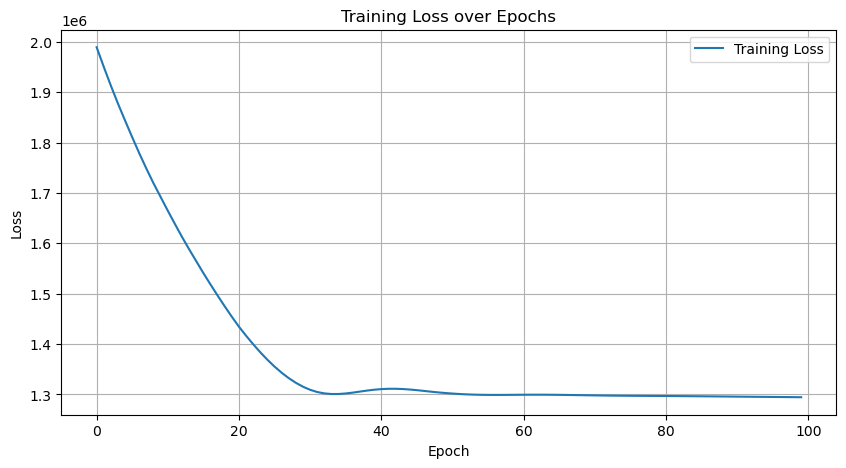

RuntimeError: Only Tensors of floating point and complex dtype can require gradients

In [11]:

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the error for a fixed time
t_fixed = torch.tensor([[5]] * 100, requires_grad=True)  # Choose a time to observe error
x_values = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)
exact_solution = np.exp(-np.pi**2*0.1)*np.sin(np.pi*x_values.numpy())  # If you have an exact solution function, apply it here

T_pred_fixed_time = model(x_values, t_fixed).detach().numpy().flatten()
error_at_fixed_time = np.abs(T_pred_fixed_time - exact_solution)

plt.figure(figsize=(10, 5))
plt.plot(x_values.detach().numpy(), error_at_fixed_time, label='Error at t = 0.5')
plt.xlabel('Position (x)')
plt.ylabel('Error |T_pred - T_exact|')
plt.title('Prediction Error at Fixed Time')
plt.legend()
plt.grid(True)
plt.show()


/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


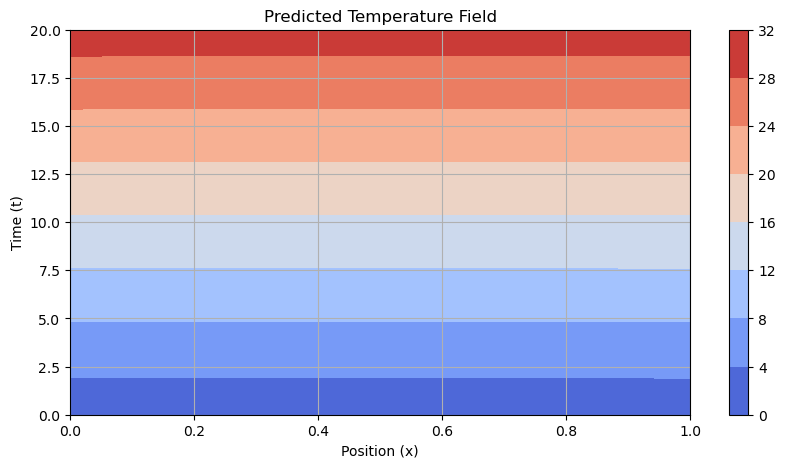

In [12]:
with torch.no_grad():
    # Plot the predicted temperature field
    X_plot, T_plot = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 20, 100)) # Create a meshgrid of X and T
    X_plot = X_plot.reshape(-1, 1)  # Flatten the meshgrid
    T_plot = T_plot.reshape(-1, 1)  # Flatten the meshgrid
    T_pred_plot = model(X_plot, T_plot).reshape(100, 100).numpy() # Predict the temperature at each (x, t) coordinate

    plt.figure(figsize=(10, 5))
    plt.contourf(X_plot[:, 0].numpy().reshape(100, 100), T_plot[:, 0].numpy().reshape(100, 100), T_pred_plot, cmap='coolwarm')
    plt.xlabel('Position (x)')
    plt.ylabel('Time (t)')
    plt.title('Predicted Temperature Field')
    plt.colorbar()
    plt.grid(True)
    plt.show()